# The model is at the end of this notebook!

In [2]:
import pandas as pd
import json
import os
from PIL import Image
import matplotlib.pyplot as plt

In [3]:
annotations_path_train = "/kaggle/input/task2-dataset/train.json"

# Load the annotations
with open(annotations_path_train, 'r') as f:
    annotations_train = json.load(f)

# Convert to a DataFrame for easier inspection
annotations_train_df = pd.DataFrame(annotations_train)

print(len(annotations_train_df))

# Display the first few rows
annotations_train_df.head()

7000


,id,text,image,labels,link
0,63292,This is why we're free\n\nThis is why we're sa...,prop_meme_556.png,"[Causal Oversimplification, Transfer, Flag-wav...",https://www.facebook.com/SilentmajorityDJT/pho...
1,65635,THIS IS WHY YOU NEED\n\nA SHARPIE WITH YOU AT ...,prop_meme_4839.png,"[Transfer, Black-and-white Fallacy/Dictatorshi...",https://www.facebook.com/photo/?fbid=402355213...
2,67927,GOOD NEWS!\n\nNAZANIN ZAGHARI-RATCLIFFE AND AN...,prop_meme_7653.png,"[Loaded Language, Glittering generalities (Vir...",https://www.facebook.com/amnesty/photos/531198...
3,68031,PAING PHYO MIN IS FREE!,prop_meme_7826.png,[Glittering generalities (Virtue)],https://www.facebook.com/amnesty/photos/427419...
4,77490,Move your ships away!\n\noooook\n\nMove your s...,prop_meme_18807.png,[Smears],https://www.facebook.com/rightpatriots/photos/...


In [4]:
print(len(annotations_train_df['labels'].explode().value_counts()))
train_label_set = set(annotations_train_df['labels'].explode())
annotations_train_df['labels'].explode().value_counts()

22


labels
Smears                                                 3640
Loaded Language                                        1751
Name calling/Labeling                                  1525
Transfer                                               1490
Appeal to authority                                     893
Flag-waving                                             813
Black-and-white Fallacy/Dictatorship                    800
Glittering generalities (Virtue)                        709
Slogans                                                 686
Thought-terminating cliché                              530
Appeal to fear/prejudice                                415
Doubt                                                   407
Exaggeration/Minimisation                               390
Appeal to (Strong) Emotions                             370
Repetition                                              306
Whataboutism                                            296
Causal Oversimplification        

ID: 77490
Text: Move your ships away!\n\noooook\n\nMove your ships away!\n\nNo, and I just added 10 more
Labels: ['Smears']


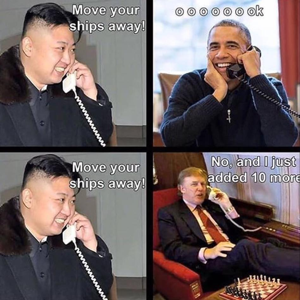

In [5]:
example = annotations_train_df.iloc[4]
print(f"ID: {example['id']}")
print(f"Text: {example['text']}")
print(f"Labels: {example['labels']}")
img = (f"/kaggle/input/task2-dataset/train_images/train_images/{example['image']}")
Image.open(img).resize((300,300))

In [6]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load a pre-trained tokenizer and model
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")
model = AutoModel.from_pretrained("bert-base-uncased")

# Tokenize and create embeddings
def get_text_embedding(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, max_length=512, padding=True)
    outputs = model(**inputs)
    # Use the CLS token representation (e.g., outputs['last_hidden_state'][:, 0, :])
    cls_embedding = outputs.last_hidden_state[:, 0, :]
    return cls_embedding

example_text = example["text"]
text_embedding = get_text_embedding(example_text)


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

# ||||||||||||

In [7]:
# Define the label mapping
labels_mapping = {
    "Logos": 0,
    "Repetition": 1,
    "Obfuscation, Intentional vagueness, Confusion": 2,
    "Reasoning": 3,
    "Justification": 4,
    "Slogans": 5,
    "Bandwagon": 6,
    "Appeal to authority": 7,
    "Flag-waving": 8,
    "Appeal to fear/prejudice": 9,
    "Simplification": 10,
    "Causal Oversimplification": 11,
    "Black-and-white Fallacy/Dictatorship": 12,
    "Thought-terminating cliché": 13,
    "Distraction": 14,
    "Misrepresentation of Someone's Position (Straw Man)": 15,
    "Presenting Irrelevant Data (Red Herring)": 16,
    "Whataboutism": 17,
    "Ethos": 18,
    "Glittering generalities (Virtue)": 19,
    "Ad Hominem": 20,
    "Doubt": 21,
    "Name calling/Labeling": 22,
    "Smears": 23,
    "Reductio ad hitlerum": 24,
    "Pathos": 25,
    "Exaggeration/Minimisation": 26,
    "Loaded Language": 27,
    "Transfer": 28,
    "Appeal to (Strong) Emotions": 29
}

import torch

# Function to encode labels as multi-hot vectors
def multi_hot_encode(labels, label_mapping):
    """
    This function takes a list of labels and returns a multi-hot encoded tensor.
    labels: List of labels that are present for an item.
    label_mapping: A dictionary mapping label names to indices.
    """
    multi_hot = torch.zeros(len(label_mapping), dtype=torch.float32)
    for label in labels:
        if label in label_mapping:
            multi_hot[label_mapping[label]] = 1
    return multi_hot

# Example: Encode the labels for a sample
sample_labels = ["Logos", "Repetition", "Reasoning"]  # Example list of labels
multi_hot_encoded = get_text_embedding(sample_labels)

print(multi_hot_encoded)



tensor([[ 0.0330,  0.3297,  0.0051,  ..., -0.1085,  0.2160,  0.2541],
        [-0.3400,  0.3807, -0.0818,  ..., -0.1381,  0.0543,  0.2079],
        [-0.2838,  0.1386, -0.0767,  ..., -0.0841,  0.0561,  0.1090]],
       grad_fn=<SliceBackward0>)


In [8]:
import torch
from torch.utils.data import Dataset, DataLoader
from transformers import CLIPProcessor, CLIPModel
import torch.nn as nn
from PIL import Image
import pandas as pd
import json

# Load annotations
annotations_path_train = "/kaggle/input/task2-dataset/train.json"
with open(annotations_path_train, "r") as f:
    annotations_train = json.load(f)

# Convert annotations to a DataFrame
annotations_train_df = pd.DataFrame(annotations_train)

# Map labels to integers if they are strings
label_mapping = {label: idx for idx, label in enumerate(annotations_train_df["labels"].explode().unique())}
annotations_train_df["labels"] = annotations_train_df["labels"].apply(
    lambda lbl_list: [label_mapping[label] for label in lbl_list]
)

# Load pre-trained CLIP model and processor
model_name = "openai/clip-vit-base-patch32"
model = CLIPModel.from_pretrained(model_name)
processor = CLIPProcessor.from_pretrained(model_name)

class CLIPWithClassificationHead(nn.Module):
    def __init__(self, clip_model, num_labels=30):
        super(CLIPWithClassificationHead, self).__init__()
        self.clip_model = clip_model
        # Add a fully connected layer on top for classification
        self.classifier = nn.Linear(clip_model.config.projection_dim, num_labels)

    def forward(self, input_ids, attention_mask, pixel_values):
        # Forward pass through the CLIP model (text and image)
        outputs = self.clip_model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
        
        # Get the image and text embeddings (you can choose either)
        image_embeddings = outputs.image_embeds  # Shape: (batch_size, projection_dim)
        text_embeddings = outputs.text_embeds     # Shape: (batch_size, projection_dim)

        # Optionally, you can concatenate or average these embeddings, depending on your task
        # Here, we're going to use the image embeddings for classification (you can change to text or a combination)
        logits = self.classifier(image_embeddings)  # Classification logits (before activation)

        probs = torch.sigmoid(logits)
        
        return probs
    
num_labels = len(labels_mapping)
model = CLIPWithClassificationHead(model)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


from torch.optim import AdamW

# Initialize optimizer
optimizer = AdamW(model.parameters(), lr=1e-4)

# Binary Cross-Entropy Loss for multi-label classification
loss_fn = nn.BCEWithLogitsLoss()

# Define Dataset
class CLIPDataset(Dataset):
    def __init__(self, annotations_df, labels_data, processor, label_mapping, image_folder, device):
        # Initialize with the given annotations DataFrame, labels, processor, and label mapping
        self.annotations_df = annotations_df
        self.labels_data = labels_data  # This is the multi-hot encoded label data
        self.processor = processor
        self.label_mapping = label_mapping
        self.device = device
        
        # Assuming 'text' and 'image_paths' are columns in the annotations_df
        self.text_data = annotations_df['text'].tolist()  # Text data
        self.image_data = annotations_df['image'].tolist()  # Image file paths or PIL images
        self.image_folder = image_folder
        
    def __len__(self):
        # The dataset size is the same as the number of rows in annotations_df
        return len(self.annotations_df)

    def __getitem__(self, idx):
        # Get the corresponding text, image path, and multi-hot encoded labels for the given index
        text = self.text_data[idx]
        image_path = self.image_data[idx]
        labels = self.labels_data[idx]  # This is the multi-hot encoded labels for the given data
        
        image_path = os.path.join(self.image_folder, image_path)
        
        # Load image (assuming image_path is the file path, adjust if using PIL images directly)
        image = Image.open(image_path).convert("RGB")
        
        # Use the processor (assuming it's CLIP processor) to process text and images
        inputs = self.processor(text=text, images=image, return_tensors="pt", padding=True, truncation=True)
        
        # Multi-hot encode the labels if not already done outside this function
        multi_hot_labels = self.multi_hot_encode(labels)

        # Move all tensors to the device (CUDA or CPU)
        input_ids = inputs["input_ids"].squeeze(0).to(self.device)  # Remove batch dimension and move to device
        attention_mask = inputs["attention_mask"].squeeze(0).to(self.device)  # Remove batch dimension and move to device
        pixel_values = inputs["pixel_values"].squeeze(0).to(self.device)  # Image tensor and move to device
        multi_hot_labels = multi_hot_labels.to(self.device)  # Multi-hot encoded labels to device
        
        # Return the processed text and image inputs along with the multi-hot labels
        return {
            "input_ids": input_ids,
            "attention_mask": attention_mask,
            "pixel_values": pixel_values,
            "label": multi_hot_labels
        } 
        
    def multi_hot_encode(self, labels):
        """
        Given the list of labels, this function will return a multi-hot encoded tensor.
        labels: List of labels for the current sample.
        """
        multi_hot = torch.zeros(len(self.label_mapping), dtype=torch.float32)
        for label in labels:
            if label in self.label_mapping:
                multi_hot[self.label_mapping[label]] = 1
        return multi_hot


# Custom collate function for DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch

def collate_fn(batch, max_input_length=77, max_label_length=30):
    # Pad input_ids and attention_mask to max_input_length
    input_ids = [item["input_ids"] for item in batch]
    attention_mask = [item["attention_mask"] for item in batch]
    pixel_values = torch.stack([item["pixel_values"] for item in batch])

    # Pad the input_ids and attention_mask
    input_ids_padded = pad_sequence(input_ids, batch_first=True, padding_value=0)
    attention_mask_padded = pad_sequence(attention_mask, batch_first=True, padding_value=0)
    
    # If needed, truncate or pad labels to max_label_length
    labels = [item["label"] for item in batch]
    labels_padded = pad_sequence(labels, batch_first=True, padding_value=-1)  # Padding with -1 for labels
    labels_padded = torch.nn.functional.pad(labels_padded, (0, max_label_length - labels_padded.size(1)))

    # Pad input_ids and attention_mask to max_input_length
    input_ids_padded = torch.nn.functional.pad(input_ids_padded, (0, max_input_length - input_ids_padded.size(1)))
    attention_mask_padded = torch.nn.functional.pad(attention_mask_padded, (0, max_input_length - attention_mask_padded.size(1)))

    return {
        "input_ids": input_ids_padded,
        "attention_mask": attention_mask_padded,
        "pixel_values": pixel_values,
        "labels": labels_padded,
    }


multi_hot_labels_data = []

# For each row in the annotations DataFrame, encode the labels to multi-hot format
for labels in annotations_train_df['labels']:  # For each sample's list of labels
    multi_hot_labels = multi_hot_encode(labels, labels_mapping)  # Assuming you have defined multi_hot_encode() function
    multi_hot_labels_data.append(multi_hot_labels)

# Create Dataset
dataset = CLIPDataset(
    annotations_df=annotations_train_df,  # This is your annotations DataFrame
    labels_data=multi_hot_labels_data,    # This is the multi-hot encoded labels (make sure you have this)
    processor=processor,                  # This is your processor (for CLIP)
    label_mapping=labels_mapping,
    image_folder="/kaggle/input/task2-dataset/train_images/train_images/",
    device=device
)

import multiprocessing
# Set the multiprocessing start method to 'spawn' for compatibility with CUDA
multiprocessing.set_start_method('spawn', force=True)

def worker_init_fn(worker_id):
    # Set a specific GPU for each worker
    os.environ["CUDA_VISIBLE_DEVICES"] = str(worker_id % torch.cuda.device_count())

# Create DataLoader
dataloader = DataLoader(dataset, batch_size=8, shuffle=True, collate_fn=collate_fn, num_workers=0, worker_init_fn=worker_init_fn)

# Test the DataLoader
for batch in dataloader:
    print("Input IDs Shape:", batch["input_ids"].shape)  # Should be [batch_size, max_seq_length]
    print("Attention Mask Shape:", batch["attention_mask"].shape)  # Same as input_ids
    print("Pixel Values Shape:", batch["pixel_values"].shape)  # Should be [batch_size, 3, height, width]
    print("Labels Shape:", batch["labels"].shape)  # Should be [batch_size]
    break

# Training Loop
for batch in dataloader:
    input_ids = batch["input_ids"].to(device)
    attention_mask = batch["attention_mask"].to(device)
    pixel_values = batch["pixel_values"].to(device)
    labels = batch["labels"].to(device)
    
    # Forward pass through the CLIP model
    with torch.no_grad():
        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
            pixel_values=pixel_values,
        )
    
    # Extract text and image embeddings
    image_embeds = outputs[0]  # Image embeddings (first element in the tuple)
    text_embeds = outputs[1]   # Text embeddings (second element in the tuple)

    
    # Compute similarity
    similarity = torch.nn.functional.cosine_similarity(text_embeds, image_embeds, dim=-1)
    print(f"Batch Similarity: {similarity}")
    
    # Print shapes for confirmation
    print("Input IDs Shape:", input_ids.shape)
    print("Pixel Values Shape:", pixel_values.shape)
    print("Labels Shape:", labels.shape)
    break



config.json:   0%|          | 0.00/4.19k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/605M [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/316 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/592 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/862k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.22M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/605M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

Input IDs Shape: torch.Size([8, 77])
Attention Mask Shape: torch.Size([8, 77])
Pixel Values Shape: torch.Size([8, 3, 224, 224])
Labels Shape: torch.Size([8, 30])
Batch Similarity: 0.9998216032981873
Input IDs Shape: torch.Size([8, 77])
Pixel Values Shape: torch.Size([8, 3, 224, 224])
Labels Shape: torch.Size([8, 30])


In [22]:
from sklearn.metrics import precision_score, f1_score
import torch
import numpy as np
from torch.utils.data import DataLoader
from transformers import CLIPProcessor, CLIPModel
from PIL import Image
import pandas as pd
import json
import os

# Assume you already have the same preprocessing steps as for training (tokenization, image loading, etc.)
# Create a validation dataset using the same CLIPDataset class from your code

def load_annotations(validation_annotations_path):
    with open(validation_annotations_path, "r") as f:
        annotations = json.load(f)
    return annotations

def prepare_validation_data(annotations_df, labels_mapping, image_folder, processor, device="cuda"):
    # Same as in training but now for validation
    multi_hot_labels_data = []
    for labels in annotations_df['labels']:
        multi_hot_labels = multi_hot_encode(labels, labels_mapping)
        multi_hot_labels_data.append(multi_hot_labels)

    validation_dataset = CLIPDataset(
        annotations_df=annotations_df,
        labels_data=multi_hot_labels_data,
        processor=processor,
        label_mapping=labels_mapping,
        image_folder=image_folder,
        device=device
    )
    
    return validation_dataset

# Define the multi-hot encode function used earlier
def multi_hot_encode(labels, label_mapping):
    multi_hot = torch.zeros(len(label_mapping), dtype=torch.float32)
    for label in labels:
        if label in label_mapping:
            multi_hot[label_mapping[label]] = 1
    return multi_hot

# The model will remain the same (CLIPWithClassificationHead)

def test_model(model, validation_dataset, batch_size=8, device='cuda'):
    model.eval()  # Set the model to evaluation mode
    
    # DataLoader for the validation set
    validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():  # No gradients needed for evaluation
        for batch in validation_dataloader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)
            
            # Forward pass through the model
            logits = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
            
            # Apply a sigmoid activation to get probabilities
            probabilities = torch.sigmoid(logits)
            
            # Convert probabilities to binary predictions (1 if probability > 0.5, else 0)
            preds = (probabilities > 0.5).float()
            
            # Collect all predictions and true labels
            all_preds.append(preds.cpu().numpy())
            all_labels.append(labels.cpu().numpy())
    
    # Flatten the list of predictions and labels for metric calculation
    all_preds = np.concatenate(all_preds, axis=0)
    all_labels = np.concatenate(all_labels, axis=0)
    
    # Calculate precision and F1 score (we use average='micro' for multi-label classification)
    precision = precision_score(all_labels, all_preds, average='micro')
    f1 = f1_score(all_labels, all_preds, average='micro')
    
    print(f"Precision: {precision:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    return precision, f1


# Example usage:

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Load validation annotations and prepare the dataset
validation_annotations_path = "/kaggle/input/task2-dataset/validation.json"
annotations_val = load_annotations(validation_annotations_path)
annotations_val_df = pd.DataFrame(annotations_val)

# The validation dataset uses the same processing and structure as the training dataset
validation_dataset = prepare_validation_data(
    annotations_df=annotations_val_df,
    labels_mapping=labels_mapping,  # Same as the one used for training
    image_folder="/kaggle/input/task2-dataset/validation_images/validation_images",  # Folder with images for validation
    processor=processor
)

# Assuming the model is already loaded as `model`
precision, f1 = test_model(model, validation_dataset, batch_size=32, device=device)


Precision: 0.0000
F1 Score: 0.0000


In [16]:
from torch.cuda.amp import autocast, GradScaler
from tqdm import tqdm
scaler = torch.amp.GradScaler()
num_epochs=3
for epoch in range(num_epochs):
    model.train()
    total_loss = 0

    with tqdm(dataloader, desc=f"Epoch {epoch+1}/{num_epochs}") as pbar:
        for batch in pbar:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            pixel_values = batch["pixel_values"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()

            # Mixed precision forward pass
            with torch.amp.autocast('cuda'):
                logits = model(input_ids=input_ids,
                               attention_mask=attention_mask,
                               pixel_values=pixel_values)
                loss = loss_fn(logits, labels.float())

            # Backward pass
            scaler.scale(loss).backward()

            # Update weights
            scaler.step(optimizer)
            scaler.update()

            total_loss += loss.item()

            # Update progress bar
            pbar.set_postfix(loss=loss.item())

    avg_loss = total_loss / len(dataloader)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {avg_loss:.4f}")


Epoch 1/3: 100%|██████████| 875/875 [06:19<00:00,  2.30it/s, loss=0.765]


Epoch 1/3, Loss: 0.8407


Epoch 2/3: 100%|██████████| 875/875 [04:43<00:00,  3.08it/s, loss=0.721]


Epoch 2/3, Loss: 0.7383


Epoch 3/3: 100%|██████████| 875/875 [04:48<00:00,  3.04it/s, loss=0.707]

Epoch 3/3, Loss: 0.7128


In [21]:
import torch
from PIL import Image
from transformers import CLIPProcessor

def predict_single_example(model, image_path, text, processor, device):
    """
    This function takes an image path and a text input, processes them with the CLIP model, 
    and returns the logits or predicted probabilities.
    
    Args:
    - model: The trained model with classification head.
    - image_path (str): Path to the image to classify.
    - text (str): The input text to classify alongside the image.
    - processor: CLIP processor for handling text and image inputs.
    - device: Device to run the model on (either 'cuda' or 'cpu').
    
    Returns:
    - logits (torch.Tensor): The raw output logits of the model.
    - predicted_labels (torch.Tensor): The multi-hot encoded prediction (0 or 1).
    """
    
    # Load and process the image
    image = Image.open(image_path).convert("RGB")
    
    # Process the text and image using the CLIP processor
    inputs = processor(text=text, images=image, return_tensors="pt", padding=True, truncation=True)
    
    # Move the inputs to the correct device (CUDA or CPU)
    input_ids = inputs["input_ids"].to(device)
    attention_mask = inputs["attention_mask"].to(device)
    pixel_values = inputs["pixel_values"].to(device)
    
    # Forward pass through the model
    with torch.no_grad():
        logits = model(input_ids=input_ids, attention_mask=attention_mask, pixel_values=pixel_values)
    
    # Apply sigmoid to convert logits to probabilities
    predicted_probs = torch.sigmoid(logits)  # Apply sigmoid to logits to get probabilities
    
    # Apply threshold to convert probabilities to binary predictions (multi-hot labels)
    predicted_labels = (predicted_probs > 0.026).float()  # 0.5 is the threshold
    
    return logits, predicted_labels


# Example usage
image_path = "/kaggle/input/task2-dataset/train_images/train_images/prop_meme_10001.png"
text = "This is George Soros.\\n\\nRemember this the next time the Soros-funded liberals call you a racist, fascist, or Nazi.\\n\\n-Abrasive Atheist"

logits, predicted_labels = predict_single_example(model, image_path, text, processor, device)

print("Logits:", logits)
print("Predicted Labels (multi-hot):", predicted_labels)


Logits: tensor([[0.0271, 0.0262, 0.0262, 0.0274, 0.0276, 0.0279, 0.0273, 0.0270, 0.0277,
         0.0268, 0.0276, 0.0273, 0.0265, 0.0281, 0.0276, 0.0268, 0.0268, 0.0277,
         0.0278, 0.0273, 0.0268, 0.0269, 0.0279, 0.0277, 0.0274, 0.0269, 0.0270,
         0.0272, 0.0266, 0.0263]], device='cuda:0')
Predicted Labels (multi-hot): tensor([[1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
         1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]], device='cuda:0')


# The final and working model is below

In [31]:
import json
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, CLIPProcessor
from PIL import Image
import torch
from torchvision import transforms

# Labels mapping
labels_mapping = {
    "Logos": 0,
    "Repetition": 1,
    "Obfuscation, Intentional vagueness, Confusion": 2,
    "Reasoning": 3,
    "Justification": 4,
    "Slogans": 5,
    "Bandwagon": 6,
    "Appeal to authority": 7,
    "Flag-waving": 8,
    "Appeal to fear/prejudice": 9,
    "Simplification": 10,
    "Causal Oversimplification": 11,
    "Black-and-white Fallacy/Dictatorship": 12,
    "Thought-terminating cliché": 13,
    "Distraction": 14,
    "Misrepresentation of Someone's Position (Straw Man)": 15,
    "Presenting Irrelevant Data (Red Herring)": 16,
    "Whataboutism": 17,
    "Ethos": 18,
    "Glittering generalities (Virtue)": 19,
    "Ad Hominem": 20,
    "Doubt": 21,
    "Name calling/Labeling": 22,
    "Smears": 23,
    "Reductio ad hitlerum": 24,
    "Pathos": 25,
    "Exaggeration/Minimisation": 26,
    "Loaded Language": 27,
    "Transfer": 28,
    "Appeal to (Strong) Emotions": 29
}

# Load the annotations
annotations_path_train = "/kaggle/input/task2-dataset/train.json"

with open(annotations_path_train, 'r') as f:
    annotations_train = json.load(f)

# Convert to DataFrame for easier inspection
annotations_train_df = pd.DataFrame(annotations_train)

# Initialize the CLIPProcessor (handles both text and image preprocessing)
processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch32")

class TextImageDataset(Dataset):
    def __init__(self, annotations, processor, labels_mapping, transform=None):
        self.annotations = annotations
        self.processor = processor  # Use the CLIPProcessor
        self.labels_mapping = labels_mapping
        self.transform = transform

    def __len__(self):
        return len(self.annotations)

    def __getitem__(self, idx):
        # Load the text and image
        annotation = self.annotations[idx]
        text = annotation['text']
        img_path = f"/kaggle/input/task2-dataset/train_images/train_images/{annotation['image']}"

        # Load the image
        img = Image.open(img_path).convert('RGB')

        # Preprocess the image and text together using CLIPProcessor
        inputs = self.processor(text=text, images=img, return_tensors="pt", padding=True, truncation=True, max_length=77)

        # Extract tokenized text and image data from processor outputs
        input_ids = inputs['input_ids'].squeeze(0)  # Remove batch dimension
        attention_mask = inputs['attention_mask'].squeeze(0)
        image = inputs['pixel_values'].squeeze(0)  # Image tensor

        # Ensure padding for all sequences to the max length
        max_length = 77  # or any max length you want to set
        pad_length = max_length - input_ids.size(0)
        
        # Pad input_ids and attention_mask if necessary
        if pad_length > 0:
            input_ids = torch.cat([input_ids, torch.zeros(pad_length, dtype=torch.long)], dim=0)
            attention_mask = torch.cat([attention_mask, torch.zeros(pad_length, dtype=torch.long)], dim=0)

        # Create a binary vector for the labels
        label_vector = torch.zeros(len(self.labels_mapping), dtype=torch.long)
        for label in annotation['labels']:
            if label in self.labels_mapping:
                label_index = self.labels_mapping[label]
                label_vector[label_index] = 1  # Set the corresponding label index to 1

        return {
            'input_ids': input_ids,
            'attention_mask': attention_mask,
            'image': image,
            'labels': label_vector
        }



# Initialize the transformations
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset and DataLoader
train_dataset = TextImageDataset(annotations_train, processor, labels_mapping, transform)
train_dataloader = DataLoader(train_dataset, batch_size=8, shuffle=True)

# Define the CLIPMultiHotClassifier (remains the same)
class CLIPMultiHotClassifier(nn.Module):
    def __init__(self, num_classes, clip_model_name='openai/clip-vit-base-patch32'):
        super(CLIPMultiHotClassifier, self).__init__()
        self.clip_model = CLIPModel.from_pretrained(clip_model_name)
        text_feature_size = self.clip_model.config.text_config.hidden_size
        image_feature_size = self.clip_model.config.projection_dim
        self.fc = nn.Linear(text_feature_size + image_feature_size, num_classes)
    
    def forward(self, images, texts):
        image_features = self.clip_model.get_image_features(images)
        text_features = self.clip_model.get_text_features(texts)
        combined_features = torch.cat((image_features, text_features), dim=1)
        logits = self.fc(combined_features)
        return torch.sigmoid(logits)

# Training loop (remains unchanged)
import torch
import torch.nn as nn
from torch.optim import Adam
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score

def train_model_with_progress_bar(model, train_dataloader, num_epochs=3, lr=1e-5):
    loss_fn = nn.BCEWithLogitsLoss()  # For multi-hot classification
    optimizer = Adam(model.parameters(), lr=lr)
    model.train()

    for epoch in range(num_epochs):
        epoch_loss = 0.0
        all_labels = []
        all_preds = []

        with tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{num_epochs}", unit="batch") as pbar:
            for batch in pbar:
                images = batch['image'].to(device)
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device).float()

                optimizer.zero_grad()
                logits = model(images, input_ids)
                loss = loss_fn(logits, labels)
                epoch_loss += loss.item()

                loss.backward()
                optimizer.step()

                preds = (logits > 0.5).float()
                all_labels.append(labels.cpu().numpy())
                all_preds.append(preds.cpu().numpy())

                pbar.set_postfix(loss=loss.item())
        
        avg_loss = epoch_loss / len(train_dataloader)
        all_labels = np.concatenate(all_labels, axis=0)
        all_preds = np.concatenate(all_preds, axis=0)
        
        accuracy = accuracy_score(all_labels.flatten(), all_preds.flatten())
        print(f"Epoch {epoch+1}/{num_epochs} - Loss: {avg_loss:.4f}, Accuracy: {accuracy:.4f}")

# Check if a GPU is available and move model to GPU if possible
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize the model and move it to GPU
num_classes = len(labels_mapping)  # 30 classes based on your labels mapping
model = CLIPMultiHotClassifier(num_classes).to(device)

# Train the model with the progress bar
train_model_with_progress_bar(model, train_dataloader, num_epochs=5, lr=1e-5)

Epoch 1/5: 100%|██████████| 875/875 [06:15<00:00,  2.33batch/s, loss=0.693]


Epoch 1/5 - Loss: 0.7046, Accuracy: 0.9239


Epoch 2/5: 100%|██████████| 875/875 [04:58<00:00,  2.93batch/s, loss=0.693]


Epoch 2/5 - Loss: 0.6928, Accuracy: 0.9275


Epoch 3/5: 100%|██████████| 875/875 [04:54<00:00,  2.97batch/s, loss=0.69] 


Epoch 3/5 - Loss: 0.6912, Accuracy: 0.9326


Epoch 4/5: 100%|██████████| 875/875 [04:56<00:00,  2.95batch/s, loss=0.69] 


Epoch 4/5 - Loss: 0.6898, Accuracy: 0.9357


Epoch 5/5: 100%|██████████| 875/875 [04:54<00:00,  2.97batch/s, loss=0.687]

Epoch 5/5 - Loss: 0.6892, Accuracy: 0.9370


In [37]:


# Convert to DataFrame for easier inspection
annotations_test_df = annotations_train_df

# Create the test dataset and dataloader
test_dataset = TextImageDataset(annotations_test, processor, labels_mapping, transform)
test_dataloader = DataLoader(test_dataset, batch_size=8, shuffle=False)

from sklearn.metrics import precision_recall_fscore_support

# Step 2: Define the evaluation function for multi-hot encoding
def evaluate_model(model, test_dataloader):
    model.eval()  # Set the model to evaluation mode
    all_labels = []
    all_preds = []
    
    with torch.no_grad():  # Disable gradient computation for evaluation
        for batch in test_dataloader:
            images = batch['image'].to(device)
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device).float()

            # Forward pass
            logits = model(images, input_ids)
            preds = (logits > 0.5).float()  # Multi-hot threshold at 0.5

            all_labels.append(labels.cpu().numpy())
            all_preds.append(preds.cpu().numpy())

    # Flatten the labels and predictions for calculating metrics
    all_labels = np.concatenate(all_labels, axis=0)
    all_preds = np.concatenate(all_preds, axis=0)
    
    # Calculate multi-hot accuracy
    accuracy = np.mean(np.all(all_labels == all_preds, axis=1))  # Accuracy per sample (all labels must match)
    print(f"Test Accuracy: {accuracy:.4f}")

    # Calculate Precision, Recall, F1 Score for each label
    precision, recall, f1, _ = precision_recall_fscore_support(all_labels.flatten(), all_preds.flatten(), average='binary')
    
    print(f"Test Precision: {precision:.4f}")
    print(f"Test Recall: {recall:.4f}")
    print(f"Test F1 Score: {f1:.4f}")

# Step 3: Evaluate the model after training
evaluate_model(model, test_dataloader)

Test Accuracy: 0.1197
Test Precision: 0.8717
Test Recall: 0.1944
Test F1 Score: 0.3178
